# MultiDVPS: Depth-Aware Video Panoptic Segmentation

This notebook demonstrates the use of the MultiDVPS model. We start by loading some checkpoint, then visualize aspects
of the outputs during both traning and inference.

In [1]:
import os

import unipercept as up
import unimodels.multidvps as multidvps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
config = up.read_config('../configs/cityscapes/multidvps_resnet50.py')
dataset, info = up.create_dataset(config, "pretrain", return_loader=False)

for _ in range(3):
    inputs =next(dataset)
    up.render.plot_input_data(inputs[0], info=info)
pass

ModuleNotFoundError: No module named 'T_extensions'

In [ ]:
model: multidvps.MultiDVPS = up.create_model(config)
print(model)

2023-11-29 09:14:46 📝 unipercept.engine: Initializing Trainer: multidvps @ cityscapes/resnet50/2023-11-29_09-14-27@gcn33.local.snellius.surf.nl
2023-11-29 09:14:46 📝 unipercept.engine: Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-29_09-14-27@gcn33.local.snellius.surf.nl


2023-11-29 09:14:46 📝 unipercept.engine: Current process: 1 / 1
Could not recover model from training session: FileNotFoundError(2, 'No such file or directory')
MultiDVPS(
  (backbone): FeaturePyramidNetwork(
    (inner_blocks): ModuleList(
      (0): Sequential(
        (co2d): Conv2d(256, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lncw): LayerNormCHW()
      )
      (1): Sequential(
        (co2d): Conv2d(512, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lncw): LayerNormCHW()
      )
      (2): Sequential(
        (co2d): Conv2d(1024, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lncw): LayerNormCHW()
      )
      (3): Sequential(
        (co2d): Conv2d(2048, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (lncw): LayerNormCHW()
      )
    )
    (layer_blocks): ModuleList(
      (0-3): 4 x Sequential(
        (se2d): Separable2d(
          (depthwise): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gr

## Parameter count

We count the model parameters for each submodule.

In [ ]:
def get_parameter_count(module: nn.Module) -> tuple[int,int]:
    """
    Returns the number of trainable and total (including non-trainable) parameters of a module.
    """
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    total = sum(p.numel() for p in module.parameters())
    return trainable, total

def make_human_readble(num: int) -> str:
    """
    Returns the integer in a human readable format, e.g. 1000 -> 1K, 1000000 -> 1M.
    """

    for unit in ["", "k"]:
        if abs(num) < 1000.0:
            return f"{num:.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} M"

def print_param_counts(mod: nn.Module, max_depth: int, *, cur_depth=0):
    """
    Prints the number of trainable and total (including non-trainable) parameters of a module and its submodules.
    """
    if cur_depth > max_depth:
        return
    trainable, total = get_parameter_count(mod)
    if total == 0:
        return
    indent = "    " * cur_depth
    name = indent + f"- {mod.__class__.__name__}"
    spacing = max(50 - len(name), 0) * " "
    print(f"{name}{spacing} : {make_human_readble(total):10s} -> {make_human_readble(trainable):10s}")
    for submod in mod.children():
        print_param_counts(submod, max_depth, cur_depth=cur_depth+1)

print_param_counts(model, 6)

- MultiDVPS                                        : 29.72 M    -> 6.19 M    
    - FeaturePyramidNetwork                        : 25.09 M    -> 1.56 M    
        - ModuleList                               : 738.82 k   -> 738.82 k  
            - Sequential                           : 49.54 k    -> 49.54 k   
                - Conv2d                           : 49.15 k    -> 49.15 k   
                - LayerNormCHW                     : 384.00     -> 384.00    
            - Sequential                           : 98.69 k    -> 98.69 k   
                - Conv2d                           : 98.30 k    -> 98.30 k   
                - LayerNormCHW                     : 384.00     -> 384.00    
            - Sequential                           : 196.99 k   -> 196.99 k  
                - Conv2d                           : 196.61 k   -> 196.61 k  
                - LayerNormCHW                     : 384.00     -> 384.00    
            - Sequential                           : 393.60 k   

To ensure compatability with specialized optimizers, e.g. fused adam, we list the unique parameter datatypes below.

In [ ]:
unique_param_dtypes = set()
for name, param in model.cuda().named_parameters():
    unique_param_dtypes.add(param.dtype)

print(f"Unique parameter dtypes: {unique_param_dtypes}")

Unique parameter dtypes: {torch.float32}


## Training forward pass

In [ ]:
inputs = inputs.cuda()
model.cuda().train()

print("benchmarking")
%timeit model(inputs)
print("benchmarking again to avoid caching")
%timeit model(inputs)
# model_cmp = torch.compile(model, backend="cudagraphs")

# print("benchmarking")
# %timeit model_cmp(inputs)

# ctx = model._forward_common(inputs.cuda())
# print(ctx)

benchmarking


The slowest run took 18.22 times longer than the fastest. This could mean that an intermediate result is being cached.
312 ms ± 485 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
benchmarking again to avoid caching
81.7 ms ± 96.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
truths = model.training_pipeline.true_segmentation(ctx)
print(truths)

NameError: name 'ctx' is not defined

fpn.3
fpn.3
fpn.4
fpn.4
fpn.5
fpn.5
fpn.6
fpn.6


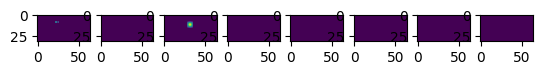

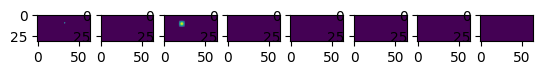

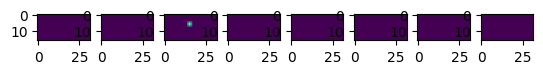

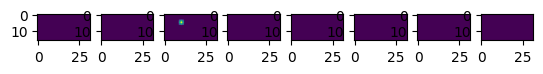

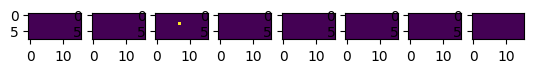

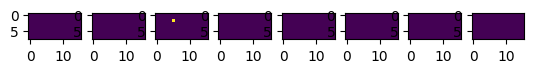

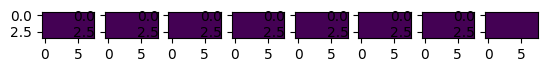

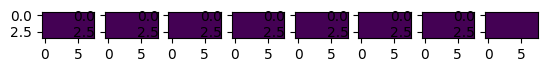

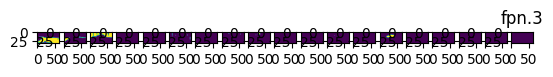

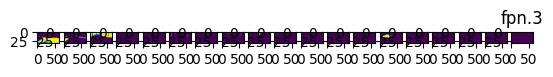

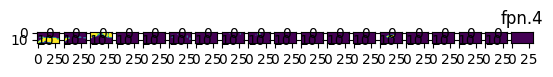

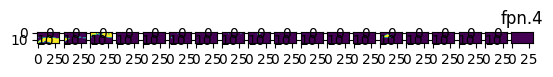

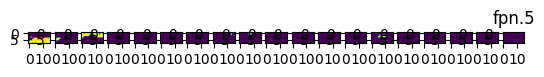

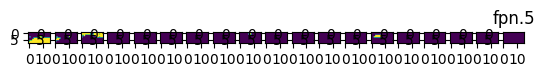

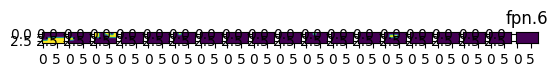

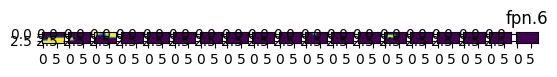

In [ ]:
for level, things in truths.thing.items():
    for things in things:
        print(level)
        
        fig, ax = plt.subplots(1, things.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(things.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
for level, stuff in truths.stuff.items():
    for stuff in stuff:
        fig, ax = plt.subplots(1, stuff.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(stuff.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
        plt.title(level)

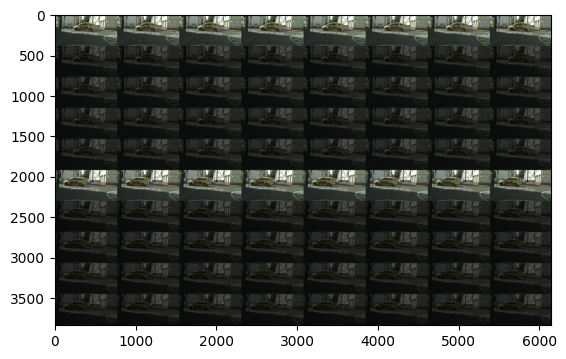

In [ ]:
vis = multidvps.visuals.visualize_true_things(ctx.captures.images, list(truths.thing.values()))
plt.imshow(vis.permute(1,2,0) / 255)

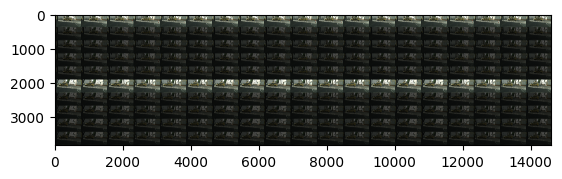

In [ ]:
vis = multidvps.visuals.visualize_true_stuff(ctx.captures.images, list(truths.stuff.values()))

plt.imshow(vis.permute(1,2,0) / vis.max())

# Inference

In [ ]:
import unipercept as up
import unimodels.multidvps as multidvps
import typing as T
import torch

config = up.read_config("../outputs/multidvps/cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl/config.yaml")

model = T.cast(multidvps.MultiDVPS, up.create_model(config, device="cuda"))
model.eval()
ds, info = up.create_dataset(config, "test")

print("Model and dataloader initialized")

for n, inputs in enumerate(ds):
    if n >= 1:
        break
    with torch.no_grad():
        inputs = inputs.cuda()
        outputs = model(inputs).cpu()
        inputs = inputs.cpu()

    print("OUTPUT FORMAT:")
    print(outputs)

2023-11-29 09:35:25 📝 unipercept.engine: Initializing Trainer: multidvps @ cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl
2023-11-29 09:35:25 📝 unipercept.engine: Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl


2023-11-29 09:35:25 📝 unipercept.engine: Current process: 1 / 1
2023-11-29 09:35:27 📝 unipercept.engine: Recovered engine state at step 80000
Recovered model from training session
2023-11-29 09:35:27 📝 unipercept.data: Wrapping dataset: CityscapesVPSDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='val', root='//datasets/cityscapes-vps', all=False)
Model and dataloader initialized
OUTPUT FORMAT:
ModelOutput(
    losses=LazyStackedTensorDict(
        fields={
        },
        exclusive_fields={
        },
        batch_size=torch.Size([1]),
        device=cpu,
        is_shared=False,
        stack_dim=0),
    metrics=LazyStackedTensorDict(
        fields={
        },
        exclusive_fields={
        },
        batch_size=torch.Size([1]),
        device=cpu,
        is_shared=False,
        stack_dim=0),
    predictions=LazyStackedTensorDict(
        fields={
            backgrounds: StuffInstances(
                categories=Tensor(shape=torch.Size([1, 1

We create some plotting utilities to visualize the outputs of the model during inference-time.

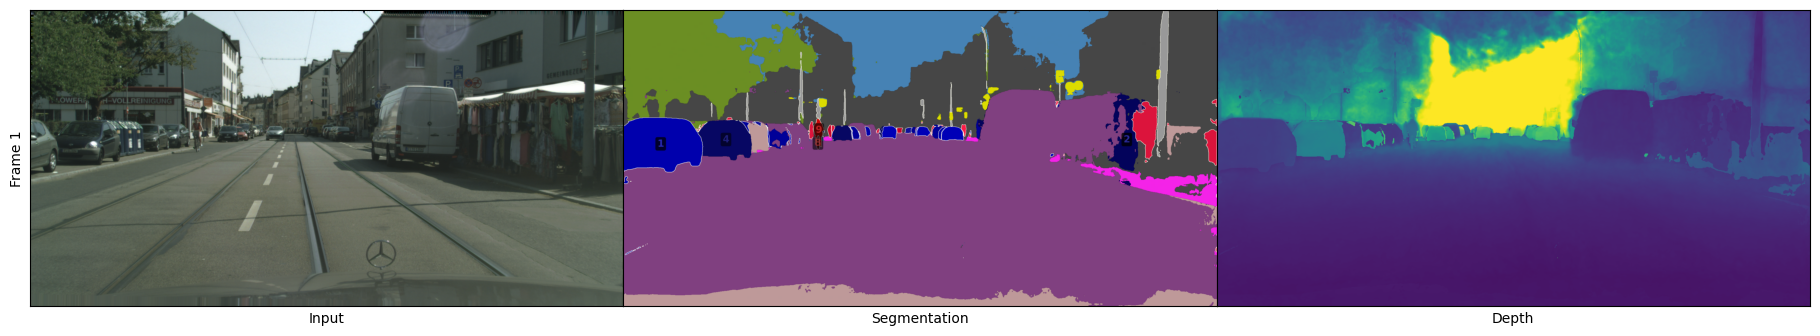

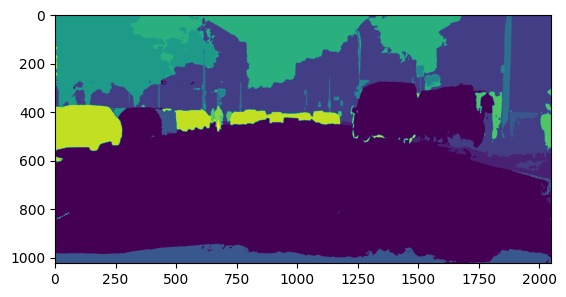

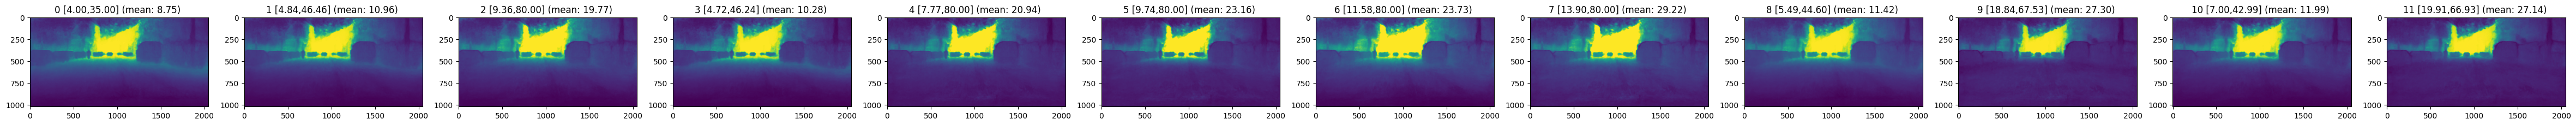

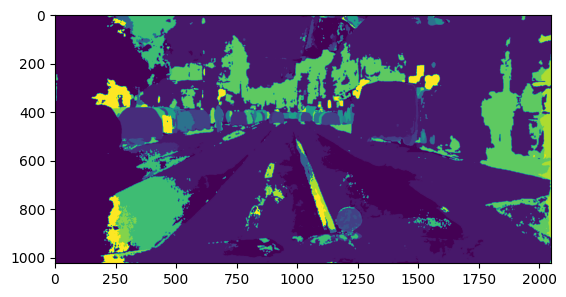

<Figure size 640x480 with 0 Axes>

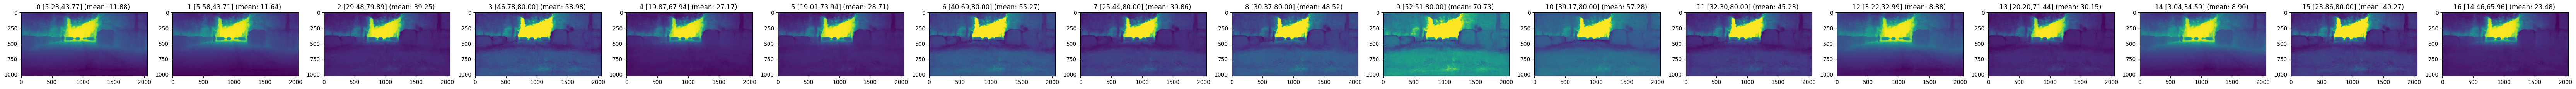

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def plot_backgrounds(outputs: up.model.ModelOutput):
    assert len(outputs.batch_size) == 0

    bgs = T.cast(multidvps.logic.StuffInstances, outputs.get(("predictions", "backgrounds")))
    # Segmentation via argmax of logits
    sem_seg = bgs.logits.argmax(dim=0)
    plt.figure()
    plt.imshow(sem_seg)
    plt.show()

    # Depth for every mask
    deps = bgs.depths.maps

    fig, axs = plt.subplots(1, deps.shape[0], squeeze=False, figsize=(deps.shape[0] * 5, 5))
    for i, dep in enumerate(deps):
        axs[0, i].imshow(dep)
        axs[0, i].set_title(f"{i} [{dep.min():.2f},{dep.max():.2f}] (mean: {bgs.depths.means[i].item():.2f}) ")
    fig.show()



def plot_objects(outputs: up.model.ModelOutput):
    assert len(outputs.batch_size) == 0

    objs = T.cast(multidvps.logic.ThingInstances, outputs.get(("predictions", "objects")))

    # Segmentation via argmax of logits
    ins_seg = objs.logits.argmax(dim=0)

    plt.figure()
    plt.imshow(ins_seg)
    plt.show()

    # Depths for every mask
    plt.figure()

    deps = objs.get(("depths", "maps"))

    fig, axs = plt.subplots(1, deps.shape[0], squeeze=False, figsize=(deps.shape[0] * 5, 5))
    for i, dep in enumerate(deps):
        axs[0, i].imshow(dep)
        axs[0, i].set_title(f"{i} [{dep.min():.2f},{dep.max():.2f}] (mean: {objs.get(('depths', 'means'))[i].item():.2f}) ")
    fig.show()

up.render.plot_predictions(inputs, outputs, info=info)
plot_backgrounds(outputs[0])
plot_objects(outputs[0])


### Inference-time geometry-encoding detectors

2023-11-29 09:39:43 📝 unipercept.engine: Initializing Trainer: multidvps @ cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl
2023-11-29 09:39:43 📝 unipercept.engine: Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/convnexts/2023-11-28_08-50-14@gcn10.local.snellius.surf.nl


2023-11-29 09:39:43 📝 unipercept.engine: Current process: 1 / 1
2023-11-29 09:39:44 📝 unipercept.engine: Recovered engine state at step 80000
Recovered model from training session


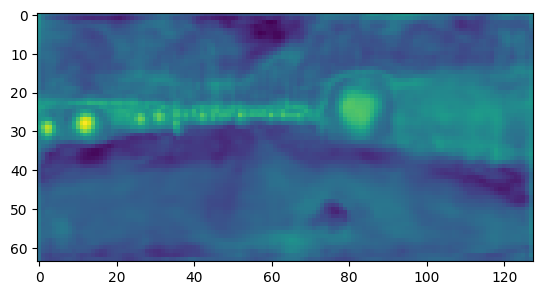

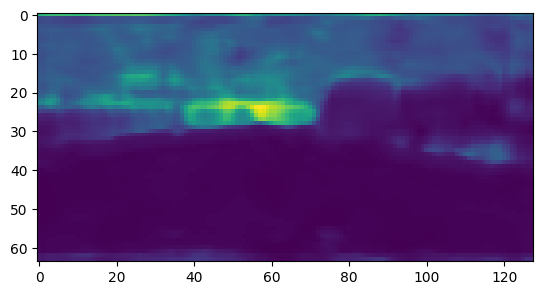

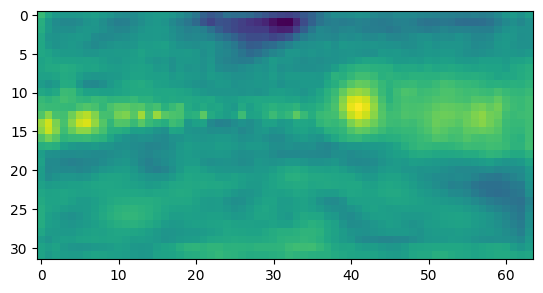

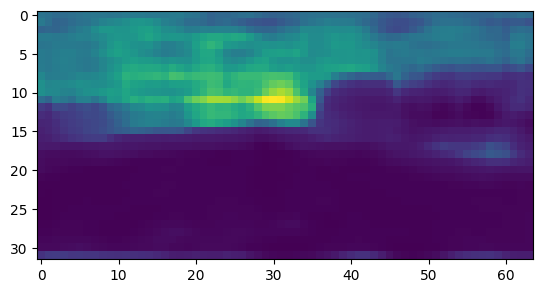

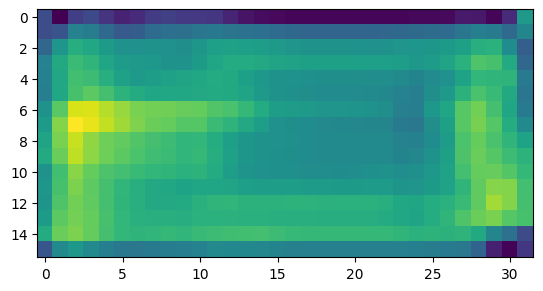

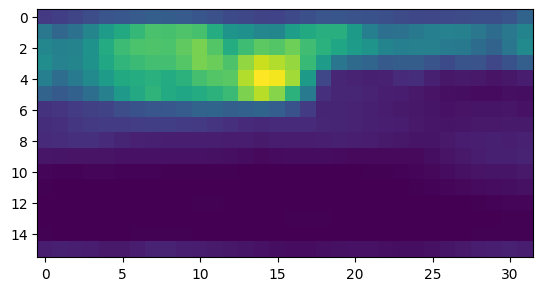

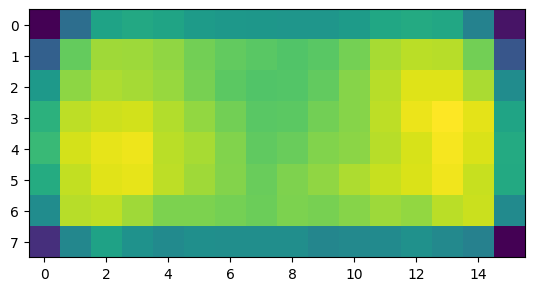

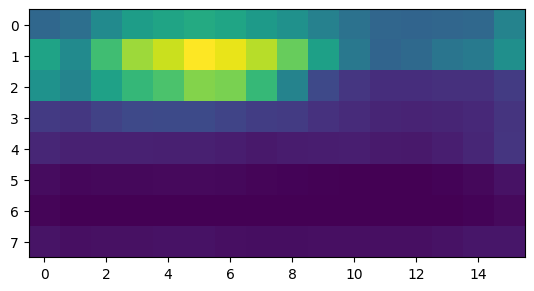

In [ ]:
def plot_geo_maps_hook(_, inputs, outputs):
    """
    Plots the geometry maps of the first batch element of the first batch.
    """

    disp_mean = outputs[0,0,:,:]
    disp_norm, depth_mean = model.depth_mapper._convert_to_absolute_depth(disp_mean)

    plt.figure()
    plt.imshow(depth_mean.cpu())
    plt.show()

def plot_score_maps_hook(_, inputs, outputs):
    """
    Plots the geometry maps of the first batch element of the first batch.
    """

    scoremaps = outputs[0,:,:,:].max(dim=0).values

    plt.figure()
    plt.imshow(scoremaps.cpu())
    plt.show()



model = T.cast(multidvps.MultiDVPS, up.create_model(config, device="cuda"))
model.eval()

hooks = []

hooks.append(model.detector.kernelizer.heads[multidvps.KEY_GEOMETRY].register_forward_hook(plot_geo_maps_hook))
hooks.append(model.detector.localizer.thing_out.register_forward_hook(plot_score_maps_hook))

with torch.no_grad():
    inputs = inputs.cuda()
    outputs = model(inputs).cpu()
    inputs = inputs.cpu()

for h in hooks:
    h.remove()